In [1]:
!nvidia-smi

Fri Dec  1 11:16:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.84                 Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   32C    P3              16W /  55W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tensorflow.keras import backend as K

In [3]:
train_path = 'dataset/train/'
val_path = 'dataset/val/'

In [4]:
def sampleImg(num):
    plt.figure(figsize=(6, 6))
    fig, ax = plt.subplots(1, 2)
    img_high_res = cv2.imread(f'dataset/train/high_res/{num}.png')
    img_low_res = cv2.imread(f'dataset/train/low_res/{num}.png')
    ax[0].imshow(img_high_res)
    ax[1].imshow(img_low_res)
    ax[0].set_title(f'High Resolution Image\n{img_high_res.shape}')
    ax[1].set_title(f'Low Resolution Image\n{img_low_res.shape}')
    plt.tight_layout()
    plt.show()

<Figure size 600x600 with 0 Axes>

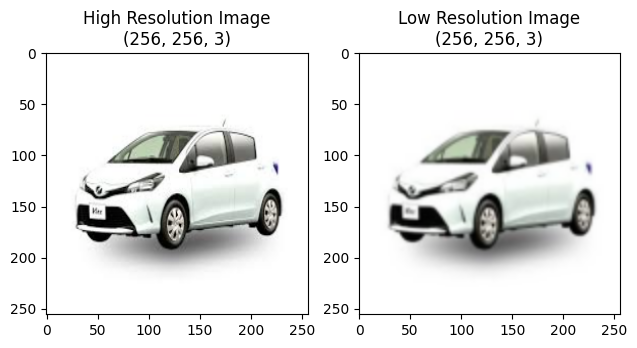

In [5]:
sampleImg(3)

In [6]:
def readImages(path):
    high_res_filenames = os.listdir(path+'/high_res/')
    low_res_filenames = os.listdir(path+'/low_res/')

    X = np.zeros((len(low_res_filenames), 256, 256, 3))
    y = np.zeros((len(high_res_filenames), 256, 256, 3))
    for i, filename in enumerate(high_res_filenames):
        y[i] = cv2.imread(path+'/high_res/'+filename)

    for i, filename in enumerate(low_res_filenames):
        X[i] = cv2.imread(path+'/low_res/'+filename)

    return X/255., y/255.

In [7]:
X_train, y_train = readImages('dataset/train')

In [8]:
X_train.shape, y_train.shape

((685, 256, 256, 3), (685, 256, 256, 3))

In [9]:
X_val, y_val = readImages('dataset/val/')

In [10]:
X_val.shape, y_val.shape

((170, 256, 256, 3), (170, 256, 256, 3))

In [11]:
def getModel(input_shape): 
    input_layer = Input(shape=input_shape, name='Input_Layer')
    conv1 = Conv2D(filters=32, kernel_size=3, padding='same', strides=2, name='Conv2D_1')(input_layer)
    batch1 = BatchNormalization(name='BatchNormalization_1')(conv1)
    leaky1 = LeakyReLU(0.3, name="LeakyReLU_1")(batch1)
    maxpool1 = MaxPool2D(pool_size=2, name='MaxPool_1')(leaky1)
    conv2 = Conv2D(filters=64, kernel_size=3, padding='same', strides=2, name='Conv2D_2')(maxpool1)
    batch2 = BatchNormalization(name="BatchNormalization_2")(conv2)
    leaky2 = LeakyReLU(0.3, name="LeakyReLU_2")(batch2)
    maxpool2 = MaxPool2D(pool_size=2, name='MaxPool_2')(leaky2)
    conv3 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer='l1', name='Conv2D_3')(maxpool2)
    maxpool3 = MaxPool2D(pool_size=2, name='MaxPool_3')(conv3)
    conv4 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer='l1', name='Conv2D_4')(maxpool3)
    maxpool4 = MaxPool2D(pool_size=2, name='MaxPool_4')(conv4)

    convt1 = Conv2DTranspose(filters=256, kernel_size=3, padding='same', activation='relu', name='Conv2DTranspose_1')(maxpool4)
    up1 = UpSampling2D(size=2, name='UpSampling2D_1')(convt1)
    convt2 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', activation='relu', name='Conv2DTranspose_2')(up1)
    up2 = UpSampling2D(size=2, name='UpSampling2D_2')(convt2)
    convt3 = Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2DTranspose_3')(up2)
    up3 = UpSampling2D(size=2, name='UpSampling2D_3')(convt3)
    add1 = add([maxpool1, up3])
    convt4 = Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2DTranspose_4')(add1)
    add2 = add([conv1, convt4])
    convt5 = Conv2DTranspose(filters=3, kernel_size=3, padding='same', activation='relu', name='Conv2DTranspose_5')(add2)
    up4 = UpSampling2D(size=2, name="UpSampling2D_4")(convt5)


    model = Model(inputs=input_layer, outputs=up4, name='Model')
    return model

In [23]:
model = getModel(input_shape=(256, 256, 3))

In [24]:
model.summary()

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv2D_1 (Conv2D)           (None, 128, 128, 32)         896       ['Input_Layer[0][0]']         
                                                                                                  
 BatchNormalization_1 (Batc  (None, 128, 128, 32)         128       ['Conv2D_1[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 LeakyReLU_1 (LeakyReLU)     (None, 128, 128, 32)         0         ['BatchNormalization_1[0][

In [25]:
def psnr(y_true, y_pred):
    y_true = K.clip(y_true, 0.0, 1.0)
    y_pred = K.clip(y_pred, 0.0, 1.0)
    mse = K.mean(K.square(y_true - y_pred))
    max_pixel = 1.0
    psnr = 20*K.log(max_pixel/K.sqrt(mse))/K.log(10.0)
    return psnr

In [26]:
def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [27]:
class SaveCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['SSIM'] >= 0.9 and logs['val_SSIM'] >= 0.85:
            print("Model saved at Epoch: ", epoch)
            self.model.save(f'models/model_1_{epoch}.h5')

In [28]:
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=[psnr, SSIM])

In [29]:
callback = SaveCallback()

In [30]:
hist = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, callbacks=[callback])

Epoch 1/1000
5/5 [==============================] - 17s 2s/step - loss: 77.2976 - psnr: 11.7600 - SSIM: 0.1228 - val_loss: 66.0197 - val_psnr: 14.1889 - val_SSIM: 0.4160
Epoch 2/1000
5/5 [==============================] - 9s 2s/step - loss: 60.9071 - psnr: 15.6180 - SSIM: 0.2138 - val_loss: 51.2112 - val_psnr: 14.9814 - val_SSIM: 0.4667
Epoch 3/1000
5/5 [==============================] - 9s 2s/step - loss: 46.8166 - psnr: 17.2281 - SSIM: 0.2518 - val_loss: 38.5479 - val_psnr: 16.0821 - val_SSIM: 0.4489
Epoch 4/1000
5/5 [==============================] - 9s 2s/step - loss: 34.8447 - psnr: 18.5713 - SSIM: 0.3222 - val_loss: 27.9304 - val_psnr: 17.4190 - val_SSIM: 0.4959
Epoch 5/1000
5/5 [==============================] - 9s 2s/step - loss: 24.9084 - psnr: 19.2826 - SSIM: 0.3912 - val_loss: 19.3409 - val_psnr: 17.6966 - val_SSIM: 0.5253
Epoch 6/1000
5/5 [==============================] - 9s 2s/step - loss: 16.9919 - psnr: 19.8343 - SSIM: 0.4150 - val_loss: 12.7750 - val_psnr: 18.4655 - va

In [31]:
model.save("models/model_1000_epochs_psnr_ssim.h5")

a:\Sem 3\Neural Networks\Project\CSCI-5922-Deep-Learning-Project\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
df = pd.DataFrame(hist.history)
df.head()

,loss,psnr,SSIM,val_loss,val_psnr,val_SSIM
0,77.297554,11.759968,0.122774,66.019745,14.188857,0.416027
1,60.907089,15.618004,0.213826,51.211182,14.981404,0.466662
2,46.816597,17.228085,0.251809,38.547867,16.082115,0.448859
3,34.844734,18.571297,0.322208,27.930372,17.418961,0.495850
4,24.908415,19.282574,0.391212,19.340935,17.696638,0.525268


In [33]:
df.to_csv("csvs/model_1000_epochs_psnr_ssim.csv", index=False)

In [34]:
model.evaluate(X_val, y_val, batch_size=32)

6/6 [==============================] - 2s 261ms/step - loss: 0.4594 - psnr: 27.3148 - SSIM: 0.8767


[0.4593523442745209, 27.31484031677246, 0.8766508102416992]

In [35]:
preds = model.predict(X_val)
preds.shape

6/6 [==============================] - 2s 123ms/step


(170, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 600x600 with 0 Axes>

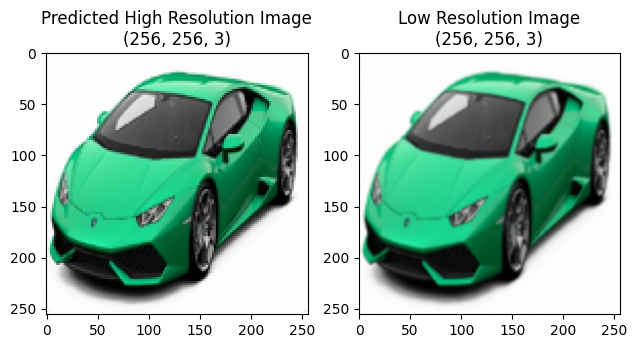

In [37]:
plt.figure(figsize=(6, 6))
fig, ax = plt.subplots(1, 2)
img_high_res = preds[155]
img_low_res = X_val[155]
ax[0].imshow(img_high_res)
ax[1].imshow(img_low_res)
ax[0].set_title(f'Predicted High Resolution Image\n{img_high_res.shape}')
ax[1].set_title(f'Low Resolution Image\n{img_low_res.shape}')
plt.tight_layout()
plt.show()

In [ ]:
plt.figur